In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pprint import pp

from utils import CONFIG

In [2]:
top_k = 50

drop_columns = [
    "device",
    "learning_rate",
    "batch_size",
    "top_k",
    "seed",
    "epochs",
    "model",
    "datasets",
    "log"
]

if False:
    for k in CONFIG.top_k:
        if k != top_k:
            drop_columns.extend([f"Precision@{k}", f"Recall@{k}", f"NDCG@{k}"])

print(drop_columns)

['device', 'learning_rate', 'batch_size', 'top_k', 'seed', 'epochs', 'model', 'datasets', 'log']


In [3]:
files = os.listdir("logs")
settings = {}

for fname in files:
    with open(f"logs/{fname}", "r", encoding="utf-8") as fin:
        lines = list(fin)
        epochs, loss, *res = lines[-1].strip().split("\t")

        d = json.loads(lines[0])

        d["Epochs"] = int(epochs)
        d["Loss"] = float(loss)

        for i, k in enumerate(CONFIG.top_k):
            precision, recall, ndcg = res[i * 3:(i * 3)+3]
            d[f"Precision@{k}"] = float(precision)
            d[f"Recall@{k}"] = float(recall)
            d[f"NDCG@{k}"] = float(ndcg)

        settings[fname[:-4]] = d

df = pd.DataFrame(settings).T.convert_dtypes()
df = df.drop(columns=drop_columns)

df

,n_layers,embedding_dim,dataset,fusion_modalities,autoencoder,multimodal,single_branch,bidirectional,freeze,Epochs,...,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
2025-01-15T18:43:58,0,64,dbbook,mean,False,False,False,False,True,218,...,0.0619,0.043,0.0645,0.064,0.0339,0.1005,0.0786,0.0229,0.1702,0.1038
2025-01-15T18:44:19,0,64,dbbook,mean,False,False,False,True,True,215,...,0.0611,0.042,0.0637,0.0628,0.0327,0.1,0.0771,0.0226,0.1699,0.1024
2025-01-15T18:44:33,0,128,dbbook,mean,False,False,False,False,True,131,...,0.0733,0.0485,0.0755,0.0746,0.037,0.1118,0.0892,0.0255,0.1888,0.1174
2025-01-15T18:44:48,0,128,dbbook,mean,False,False,False,True,True,133,...,0.0712,0.047,0.0747,0.0732,0.0364,0.1114,0.0882,0.0246,0.1855,0.1149
2025-01-15T18:45:01,0,256,dbbook,mean,False,False,False,False,True,89,...,0.0804,0.0526,0.082,0.0815,0.0394,0.1211,0.097,0.0262,0.1975,0.1247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-15T23:28:05,4,128,dbbook,max,False,True,False,True,True,1000,...,0.0714,0.049,0.0782,0.0742,0.0373,0.117,0.0898,0.0257,0.2002,0.1192
2025-01-15T23:35:42,4,256,dbbook,mean,False,True,False,False,True,1000,...,0.0936,0.0634,0.1005,0.0971,0.0481,0.1485,0.1165,0.0322,0.2451,0.1513
2025-01-15T23:46:56,4,256,dbbook,mean,False,True,False,True,True,1000,...,0.0712,0.0495,0.0801,0.0749,0.0377,0.1204,0.091,0.0255,0.202,0.1197
2025-01-15T23:54:33,4,256,dbbook,max,False,True,False,False,True,1000,...,0.093,0.063,0.1005,0.0958,0.0479,0.1494,0.1154,0.0318,0.2438,0.1494


In [4]:
df.where(
    (df["embedding_dim"] == 256) & (df["dataset"] == "dbbook") & (df["fusion_modalities"] == "max")
).groupby(
    ["bidirectional", "multimodal", "n_layers"]
)[["Precision@50", "Recall@50", "NDCG@50", "Loss", "Epochs"]].mean()

Precision@50  Recall@50  NDCG@50    Loss  \
bidirectional multimodal n_layers                                             
False         True       0               0.0305      0.229   0.1448    0.01   
                         1               0.0299     0.2301   0.1462  0.0168   
                         2               0.0311     0.2394   0.1491  0.0314   
                         3               0.0319     0.2446    0.152  0.0491   
                         4               0.0318     0.2438   0.1494  0.0699   
True          True       0               0.0304     0.2319    0.144  0.0097   
                         1               0.0269     0.2116   0.1264    0.01   
                         2               0.0267     0.2109    0.128  0.0099   
                         3               0.0246     0.1964   0.1167  0.0126   
                         4               0.0258     0.2027   0.1205  0.0149   

                                   Epochs  
bidirectional multimodal n_layers          
False         True       0          158.0  
                         1         1000.0  
                         2         1000.0  
                         3         1000.0  
                         4         1000.0  
True          True       0          154.0  
                         1          240.0  
                         2          641.0  
                         3         1000.0  
                         4         1000.0

In [5]:
df.rename(columns={"embedding_dim": "emb_dim", "fusion_modalities": "fusion"}).where(df["multimodal"] == False).groupby("n_layers")[["Precision@10", "Recall@10", "NDCG@10"]].mean()

,Precision@10,Recall@10,NDCG@10
n_layers,,,
0,0.0474,0.073333,0.072283
1,0.0479,0.075917,0.0729
2,0.051083,0.080533,0.0774
3,0.04985,0.0793,0.074933
4,0.050033,0.079383,0.0755


In [6]:
file = os.listdir("logs")[-1]
file_path = f"logs/{file}"

with open(file_path, 'r') as f:
    config_line = f.readline().strip()
    config = json.loads(config_line)

data = pd.read_csv(file_path, sep='\t', skiprows=1)

In [7]:
data

,Epoch,Loss,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
0,1,0.6920,0.0369,0.0270,0.0366,0.0346,0.0501,0.0430,0.0293,0.0831,0.0572,0.0220,0.1591,0.0844
1,2,0.6846,0.0302,0.0218,0.0277,0.0288,0.0397,0.0330,0.0240,0.0652,0.0438,0.0200,0.1380,0.0707
2,3,0.6589,0.0276,0.0194,0.0255,0.0257,0.0348,0.0298,0.0222,0.0598,0.0404,0.0187,0.1275,0.0655
3,4,0.6042,0.0255,0.0175,0.0238,0.0248,0.0331,0.0285,0.0216,0.0579,0.0390,0.0180,0.1220,0.0630
4,5,0.5315,0.0245,0.0165,0.0230,0.0248,0.0331,0.0284,0.0214,0.0573,0.0385,0.0179,0.1204,0.0623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0.0148,0.0612,0.0498,0.0710,0.0496,0.0799,0.0748,0.0379,0.1219,0.0914,0.0258,0.2025,0.1202
996,997,0.0149,0.0612,0.0498,0.0711,0.0496,0.0802,0.0751,0.0379,0.1221,0.0916,0.0258,0.2026,0.1203
997,998,0.0153,0.0614,0.0500,0.0714,0.0496,0.0800,0.0751,0.0379,0.1222,0.0916,0.0258,0.2029,0.1204
998,999,0.0152,0.0615,0.0496,0.0713,0.0497,0.0803,0.0752,0.0379,0.1221,0.0916,0.0258,0.2031,0.1204


In [8]:
epochs = data["Epoch"]
loss = data["Loss"]

{'n_layers': 4,
 'device': 'cuda',
 'batch_size': 2048,
 'embedding_dim': 256,
 'learning_rate': 0.001,
 'dataset': 'dbbook',
 'epochs': 1000,
 'model': 'ef-mmlgcn',
 'fusion_modalities': 'max',
 'top_k': [5,
           10,
           20,
           50],
 'seed': 19,
 'autoencoder': False,
 'multimodal': True,
 'single_branch': False,
 'bidirectional': True,
 'freeze': True,
 'log': True,
 'datasets': {'dbbook': ['images',
                         'text'],
              'ml1m': ['audio',
                       'images',
                       'text',
                       'video']}}

Epoch           1000.0000
Loss               0.0149
Precision@5        0.0616
Recall@5           0.0501
NDCG@5             0.0715
Precision@10       0.0498
Recall@10          0.0806
NDCG@10            0.0754
Precision@20       0.0379
Recall@20          0.1220
NDCG@20            0.0917
Precision@50       0.0258
Recall@50          0.2027
NDCG@50            0.1205
Name: 999, dtype: float64


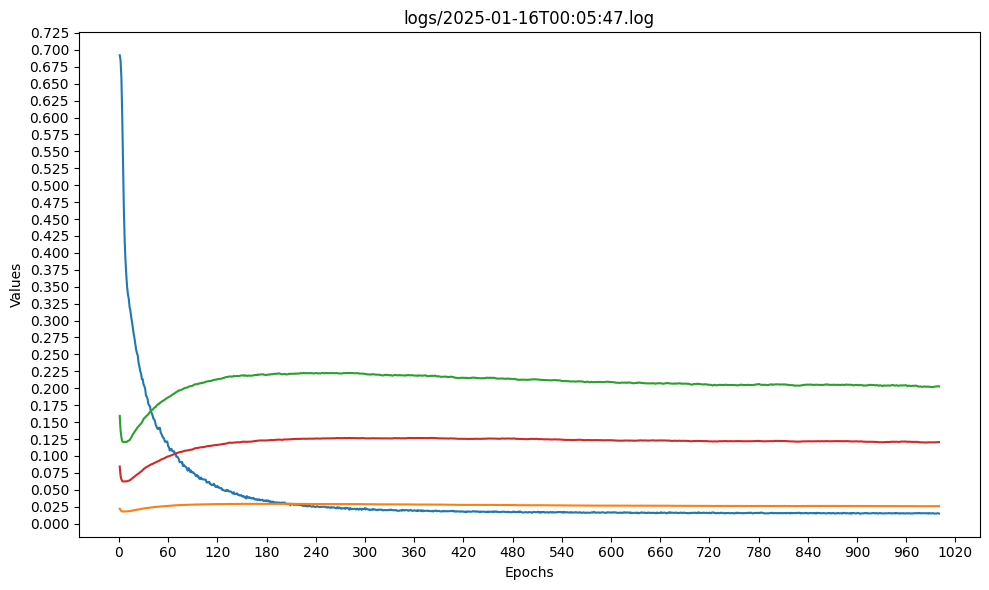

In [9]:
pp(config, width=1)
print()
print(data.iloc[-1])

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss, label="Loss")

for k in [50]:
    plt.plot(epochs, data[f"Precision@{k}"], label=f"Precision@{k}")
    plt.plot(epochs, data[f"Recall@{k}"], label=f"Recall@{k}")
    plt.plot(epochs, data[f"NDCG@{k}"], label=f"NDCG@{k}")


plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title(file_path)
#plt.legend()

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=30))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
#plt.yscale("log")

plt.tight_layout()
plt.show()